In [4]:
import os, sys
sys.path.insert(1, '../dataset')
import numpy as np
import pandas as pd
import warnings
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
import torch
from utils import tag_to_word_df

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [18]:
#prepare data
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
if not os.path.exists('../dataset/prepared'):
    os.makedirs('../dataset/prepared')

def data_preparation(data):
    # Clean the text
    data['Tokens'] = data['Tokens'].str.lower()
    data['Tokens'] = data['Tokens'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    data['Tokens'] = data['Tokens'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    data['Tokens'] = data['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

    return data

dataP = pd.read_csv('../dataset/restaurants_train.csv')
data_testP = pd.read_csv('../dataset/restaurants_test.csv')

data_testP = data_preparation(data_testP)
dataP = data_preparation(dataP)
# data_preparation.to_csv('../dataset/restaurants_test.csv')
# data_preparation.to_csv('../dataset/restaurants_train.csv')


In [19]:
# spelling check
from textblob import TextBlob
import contractions

def normalize(data):
    d = data
    def correct(token_list):
        l = token_list.replace("'", "").strip("][").split(', ')
        # abbreviations
        l = [contractions.fix(ll) for ll in l ]
        s = ' '.join(l)
        s = str(TextBlob(s).correct().words)
        return s 
    d['Tokens'] = d['Tokens'].apply(lambda x: correct(x))
    return d

#load
data = pd.read_csv('../dataset/prepared/restaurants_train.csv')
data_test = pd.read_csv('../dataset/prepared/restaurants_test.csv')

data_test = normalize(data_test)
data = normalize(data)

In [20]:
#normalized data
if not os.path.exists('../dataset/normalized'):
    os.makedirs('../dataset/normalized')
data_test.to_csv('../dataset/normalized/restaurants_test.csv', index=False)
data.to_csv('../dataset/normalized/restaurants_train.csv', index=False)

In [2]:
from abte import ABTEModel

batch = 8
lr = 3*1e-5
epochs = 5

def run_ABTE_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
        else: dir_name = "model_ABTE_adapter"
    else:
        if lr_schedule: dir_name  = "model_ABTE_scheduler"
        else: dir_name = "model_ABTE"

    #load
    data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
    data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

    # define parameters for model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # define model
    modelABTE = ABTEModel(tokenizer, adapter=adapter)

    # load model and predict
    model_path = '../'+dir_name+'/model_lr3.0000000000000004e-05_epochs4_batch8.pkl'
    test_accuracy, test_report = modelABTE.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_targets = modelABTE.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABTE.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_targets = modelABTE.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists('/results'):
        os.makedirs(dir_name+'/results')

    #report
    with open(dir_name+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_targets
    data_test.to_csv(dir_name+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_targets
    data.to_csv(dir_name+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))


C:\Users\shivani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
run_ABTE_test_train(False, True)
run_ABTE_test_train(False, False)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [12]:
dftest = pd.read_csv('../src/model_ABTE_scheduler/results/test_pred_lr3.0000000000000004e-05_epochs5_batch8.csv')
test_pred = dftest['Predicted']

#load
data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

test_tags_real = [t.strip('][').split(', ') for t in data_test['Tags']]
test_tags_real = [[int(i) for i in t] for t in test_tags_real]

test_pred = [t.strip('][').split(', ') for t in test_pred]
test_pred = [[int(i) for i in t] for t in test_pred]


ABTE_data = tag_to_word_df(data_test, 'gold terms', test_tags_real)
ABTE_data = tag_to_word_df(ABTE_data, 'pred terms', test_pred)
ABTE_data.head(10)

,Tokens,Tags,Polarities,gold terms,pred terms
0,"['The', 'bread', 'is', 'top', 'notch', 'as', '...","[0, 1, 0, 0, 0, 0, 0, 0]","[-1, 2, -1, -1, -1, -1, -1, -1]",[bread],[bread]
1,"['I', 'have', 'to', 'say', 'they', 'have', 'on...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2,...",[delivery],[times]
2,"['Good', 'is', 'always', 'fresh', 'and', 'hot'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]",[Good],[Good]
3,"['Did', 'I', 'mention', 'that', 'the', 'coffee...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[-1, -1, -1, -1, -1, 2, -1, -1, -1]",[coffee],[coffee]
4,"['Certainly', 'not', 'the', 'best', 'such', 'i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",[clean],[is]
5,"['I', 'trust', 'the', 'people', 'at', 'To', 'T...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]",[people],[]
6,"['Straight-forward', 'no', 'surprise', 'very',...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, -1, 2, 2, -1]",[],[]
7,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, 2, 2, -1]",[],"[spice, asia]"
8,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 1, 2, 2, 0, 0, 0, 0, 0]","[-1, 2, 2, 2, -1, -1, -1, -1, -1]",[spice],"[spice, asia]"
9,"['Cry', 'the', 'rose', 'roll', 'LRB', 'not', '...","[0, 0, 1, 2, 0, 0, 0, 1, 0, 0]","[-1, -1, 2, 2, -1, -1, -1, -1, -1, -1]","[rose, menu]",[rose]


In [38]:
def word_cloud (data):
    from wordcloud import WordCloud
    wordcloud = WordCloud( collocations=False,
                          background_color="cornflowerblue",
                          colormap="magma",
                          max_words=50).generate(data)

    return wordcloud

def target_predicted_wordcloud(targets, predicted, file_name):
    
    sns.set_theme(style='white', font_scale=2)
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    ax[0].imshow(word_cloud(targets))
    ax[0].axis("off")
    ax[0].set_title("Target")
    ax[1].imshow(word_cloud(predicted))
    ax[1].axis("off")
    ax[1].set_title("Predicted")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')

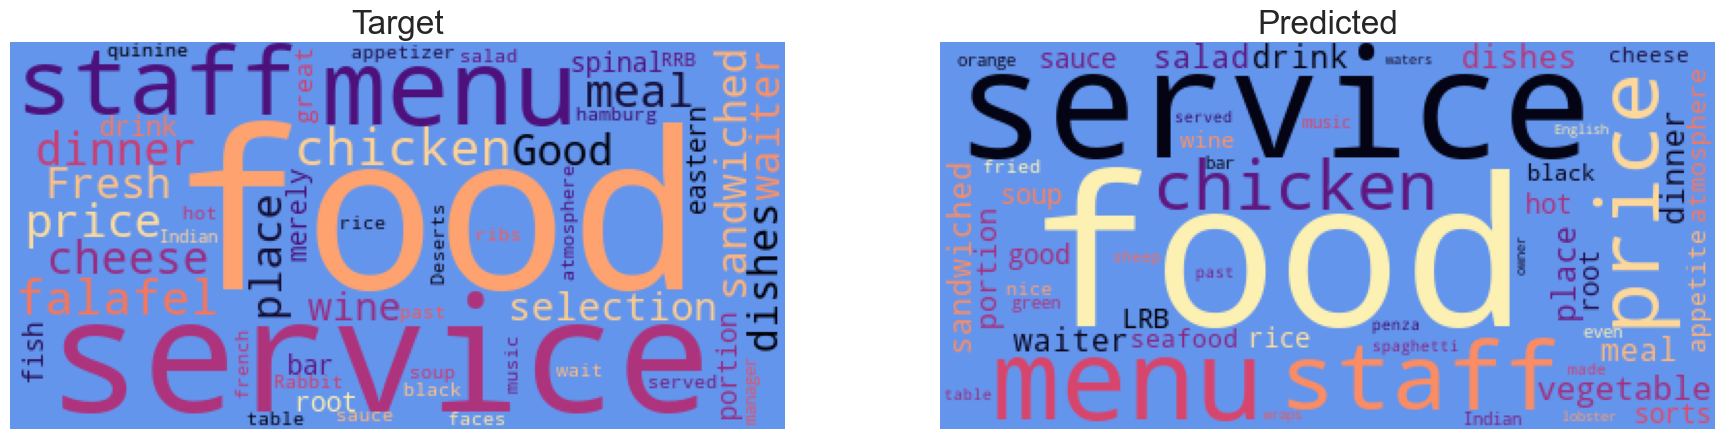

In [16]:
import itertools

gold_terms = ABTE_data['gold terms'].values.flatten().tolist()
gold_terms = list(itertools.chain(*gold_terms))

pred_terms = ABTE_data['pred terms'].values.flatten().tolist()
pred_terms = list(itertools.chain(*pred_terms))
target_predicted_wordcloud(' '.join(gold_terms), ' '.join(pred_terms), "../Results_ABTE/adapter_extracted_terms_wordcloud.pdf")


In [ ]:
run_ABTE_test_train(False, False)
run_ABTE_test_train(False, True)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
dftest = pd.read_csv('../src/model_ABTE/results/test_pred_lr3.0000000000000004e-05_epochs5_batch8.csv')
test_pred = dftest['Predicted']

#load
data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

test_tags_real = [t.strip('][').split(', ') for t in data_test['Tags']]
test_tags_real = [[int(i) for i in t] for t in test_tags_real]

test_pred = [t.strip('][').split(', ') for t in test_pred]
test_pred = [[int(i) for i in t] for t in test_pred]


ABTE_data = tag_to_word_df(data_test, 'gold terms', test_tags_real)
ABTE_data = tag_to_word_df(ABTE_data, 'pred terms', test_pred)
ABTE_data.head(10)

,Tokens,Tags,Polarities,gold terms,pred terms
0,"['The', 'bread', 'is', 'top', 'notch', 'as', '...","[0, 1, 0, 0, 0, 0, 0, 0]","[-1, 2, -1, -1, -1, -1, -1, -1]",[bread],[bread]
1,"['I', 'have', 'to', 'say', 'they', 'have', 'on...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2,...",[delivery],"[times, in]"
2,"['Good', 'is', 'always', 'fresh', 'and', 'hot'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]",[Good],"[Good, ready]"
3,"['Did', 'I', 'mention', 'that', 'the', 'coffee...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[-1, -1, -1, -1, -1, 2, -1, -1, -1]",[coffee],"[coffee, is]"
4,"['Certainly', 'not', 'the', 'best', 'such', 'i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",[clean],"[such, place, is]"
5,"['I', 'trust', 'the', 'people', 'at', 'To', 'T...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]",[people],[people]
6,"['Straight-forward', 'no', 'surprise', 'very',...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, -1, 2, 2, -1]",[],[surprise]
7,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, 2, 2, -1]",[],"[spice, asia]"
8,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 1, 2, 2, 0, 0, 0, 0, 0]","[-1, 2, 2, 2, -1, -1, -1, -1, -1]",[spice],"[spice, asia]"
9,"['Cry', 'the', 'rose', 'roll', 'LRB', 'not', '...","[0, 0, 1, 2, 0, 0, 0, 1, 0, 0]","[-1, -1, 2, 2, -1, -1, -1, -1, -1, -1]","[rose, menu]",[rose]


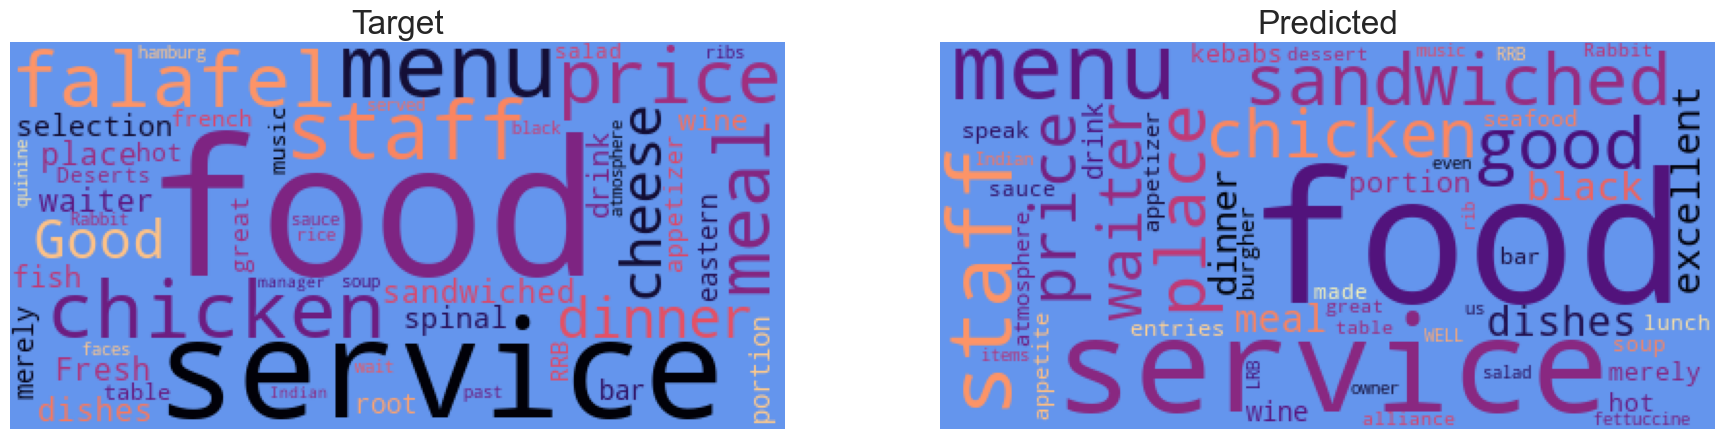

In [39]:
import itertools
gold_terms = ABTE_data['gold terms'].values.flatten().tolist()
gold_terms = list(itertools.chain(*gold_terms))

pred_terms = ABTE_data['pred terms'].values.flatten().tolist()
pred_terms = list(itertools.chain(*pred_terms))
target_predicted_wordcloud(' '.join(gold_terms), ' '.join(pred_terms), "../Results_ABTE/adapter_extracted_terms_wordcloud_without_scheduler.pdf")

In [13]:
from absa import ABSAModel

#save results
batch = 8
lr = 1e-5
epochs = 5

def run_ABSA_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name_s  = "model_ABSA_adapter_scheduler"
        else: dir_name_s = "model_ABSA_adapter"
    else:
        if lr_schedule: dir_name_s  = "model_ABSA_scheduler"
        else: dir_name_s = "model_ABSA"

    #load
    data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
    data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    modelABSA = ABSAModel(tokenizer, adapter=adapter)

    model_path = '../'+dir_name_s+'/model_lr1e-05_epochs4_batch8.pkl'
    test_accuracy, test_report = modelABSA.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_pol = modelABSA.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABSA.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_pol = modelABSA.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists(dir_name_s+'/results'):
        os.makedirs(dir_name_s+'/results')

    #report
    with open(dir_name_s+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name_s+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_pol
    data_test.to_csv(dir_name_s+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_pol
    data.to_csv(dir_name_s+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name_s+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name_s+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))


In [11]:
run_ABSA_test_train(False, False)
run_ABSA_test_train(False, True)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [16]:
from utils import classification_report_read, print_aligned

test_ABSA = classification_report_read('../src/model_ABSA/results/test_report_lr1e-05_epochs5_batch8.csv')
test_ABSA_S = classification_report_read('../src/model_ABSA_scheduler/results/test_report_lr1e-05_epochs5_batch8.csv')

print_aligned(test_ABSA, test_ABSA_S, 'TEST FINE-TUNING', 'TEST FINE-TUNING+SCHEDULER')

	 TEST FINE-TUNING 						 TEST FINE-TUNING+SCHEDULER
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
    negative       0.89      0.60      0.71       267 		     negative       0.82      0.77      0.80       267
     neutral       0.69      0.26      0.37       179 		      neutral       0.72      0.28      0.41       179
    positive       0.75      0.97      0.85       673 		     positive       0.81      0.96      0.88       673
 		 
    accuracy                           0.77      1119 		     accuracy                           0.81      1119
   macro avg       0.78      0.61      0.65      1119 		    macro avg       0.78      0.67      0.69      1119
weighted avg       0.77      0.77      0.74      1119 		 weighted avg       0.80      0.81      0.78      1119
 		 
 		 


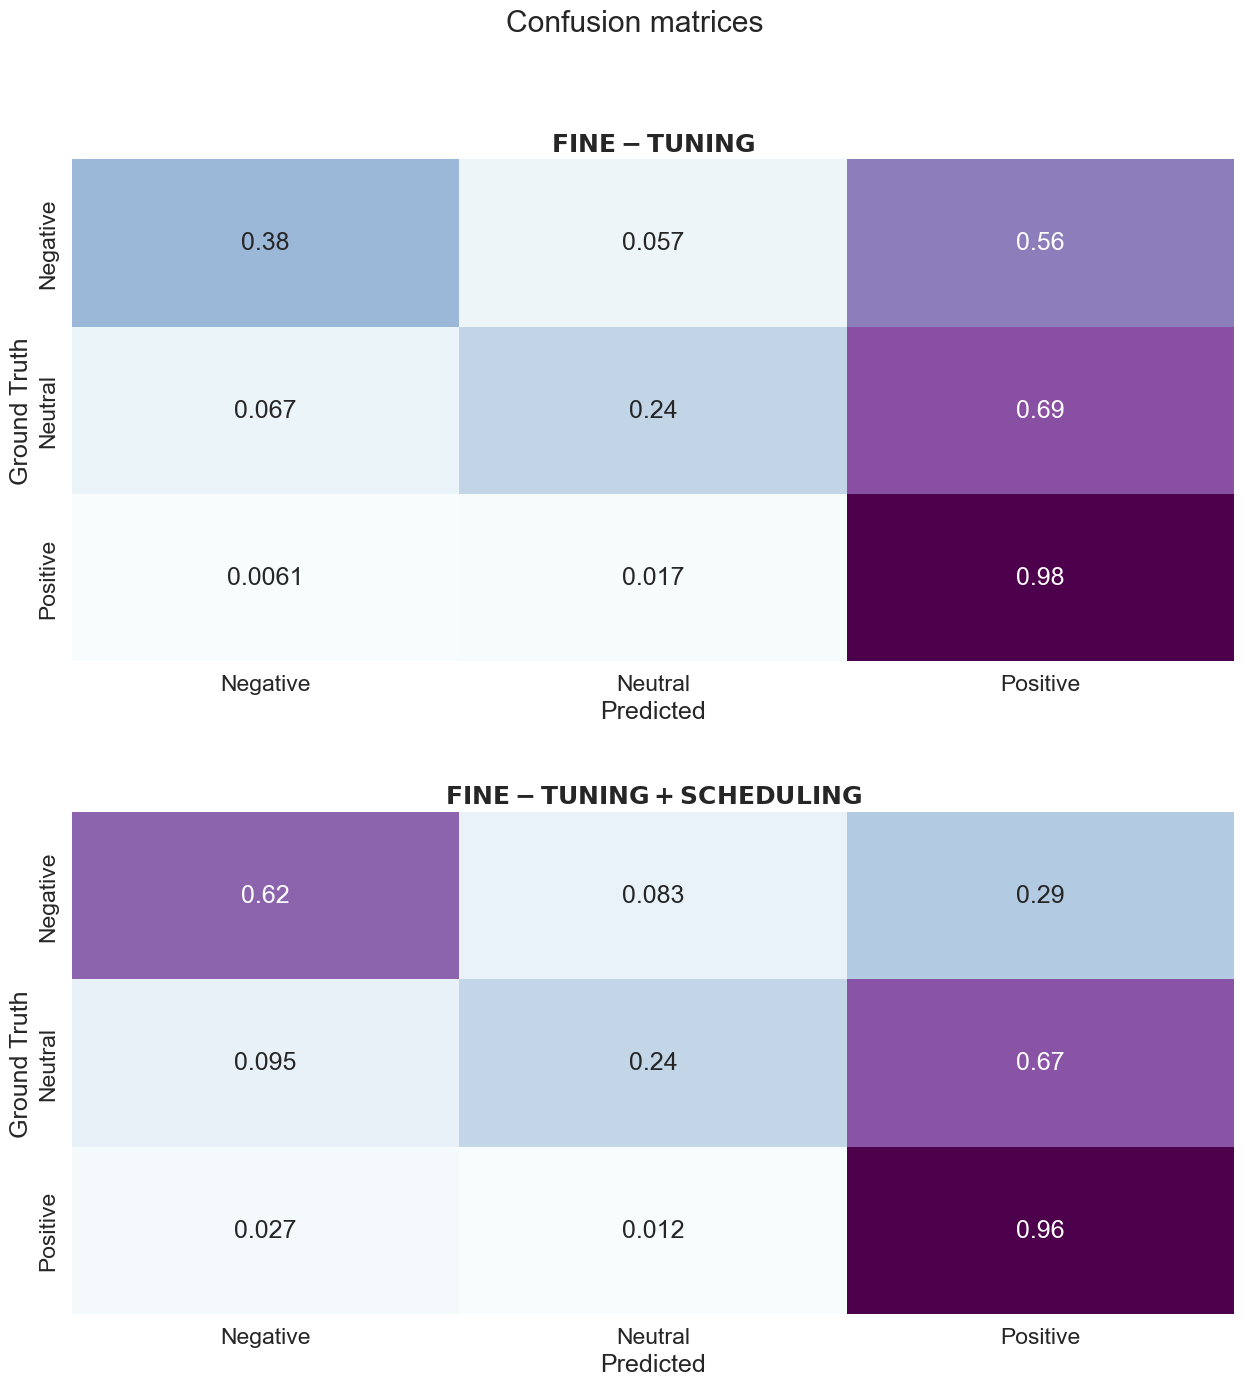

In [23]:
# confusion matrix 
def plot_confusion_matrix(predictions, labels, title, ax, 
                          cmap='BuPu'):
    """
    This function prints and plots the confusion matrix.
    """
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(labels, predictions, normalize = 'true')
    cm = cm[1:,1:]
    sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5)
    sns.heatmap(cm, annot=True,  cmap=cmap, ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel('Ground Truth'),ax.set_xlabel('Predicted')
    
def plot_confusion_matrix_df(df_path, title, ax, cmap='BuPu'):

    df = pd.read_csv(df_path)
    pred = df['Predicted'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    gtruth = df['Actual'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    predicted, ground_truth = [], []
    for i in range(len(pred)):
        predicted+=pred[i]
        ground_truth+=gtruth[i]
    plot_confusion_matrix(predicted, ground_truth, title, ax, cmap=cmap)

def compare_confusion_mat():
    df = '../src/model_ABSA/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfS = '../src/model_ABSA_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv'
    fig, ax = plt.subplots(2,figsize=(15,15))
    #set space between subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    fig.suptitle('Confusion matrices')
    plot_confusion_matrix_df(df, r'$\bf{FINE-TUNING}$', ax[0])
    plot_confusion_matrix_df(dfS, r'$\bf{FINE-TUNING + SCHEDULING}$', ax[1])
    
    fig.savefig('../Results_ABSA/CMatrix_test.png', dpi=300, bbox_inches='tight')

compare_confusion_mat()


In [1]:
def find_aspect(review, model, model_path):
    x, y, z = modelABTE.predict(review, load_model=model_path)
    words = review.split()
    aspects = []
    i = 0
    while i < len(y):
        if y[i] == 1:
            aspect = [words[i]]
            i += 1
            while i < len(y) and y[i] == 2:
                aspect.append(words[i])
                i += 1
            aspects.append(" ".join(aspect))
        else:
            i += 1
    return aspects

In [2]:
from transformers import BertTokenizer
import torch
from absa import ABSAModel
from abte import ABTEModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelABTE = ABTEModel(tokenizer, adapter=False)
model_path = '../model_ABTE_scheduler/model_lr3.0000000000000004e-05_epochs4_batch8.pkl'
model_path2 = '../model_ABSA_scheduler/model_lr1e-05_epochs4_batch8.pkl'
modelABSA = ABSAModel(tokenizer, adapter=False) 

C:\Users\shivani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords and punkt tokenizer if not already present
nltk.download('punkt')
punctuations = set(string.punctuation)

def preprocess_review(review):
    review = review.lower()
    tokens = word_tokenize(review)
    cleaned_tokens = [word for word in tokens if word not in punctuations]
    cleaned_review = ' '.join(cleaned_tokens)
    return cleaned_review


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
review1 = preprocess_review("they make the BEST spice tuna roll in town, and the asian salad is ok.")
review2 = preprocess_review("the food is fantastic, and so are the drinks!")
review3 = preprocess_review("the chicken tastes like plastic, even tough they make the best.")

In [5]:
def predict_sentiments_for_aspects(review, aspects, model, model_path):
    sentiments = []
    for aspect in aspects:
        x, y, z = model.predict(review, aspect, load_model=model_path)
        if y == 1:
            sentiment = 'positive'
        elif y == 0:
            sentiment = 'neutral'
        else:
            sentiment = 'negative'
        sentiments.append((aspect, sentiment))
    return sentiments


In [9]:
aspects1 = find_aspect(review1, modelABTE, model_path)
aspects2 = find_aspect(review2, modelABTE, model_path)
aspects3 = find_aspect(review3, modelABTE, model_path)

for aspect, sentiment in predict_sentiments_for_aspects(review1, aspects1, modelABSA, model_path2):
    print(f'The review "{review1}"\nw.r.t. the aspect "{aspect}" is {sentiment}\n')

for aspect, sentiment in predict_sentiments_for_aspects(review2, aspects2, modelABSA, model_path2):
    print(f'The review "{review2}"\nw.r.t. the aspect "{aspect}" is {sentiment}\n')

for aspect, sentiment in predict_sentiments_for_aspects(review3, aspects3, modelABSA, model_path2):
    print(f'The review "{review3}"\nw.r.t. the aspect "{aspect}" is {sentiment}\n')


The review "they make the best spice tuna roll in town and the asian salad is ok"
w.r.t. the aspect "spice tuna roll" is positive

The review "they make the best spice tuna roll in town and the asian salad is ok"
w.r.t. the aspect "asian salad" is positive

The review "the food is fantastic and so are the drinks"
w.r.t. the aspect "food" is positive

The review "the food is fantastic and so are the drinks"
w.r.t. the aspect "drinks" is positive

The review "the chicken tastes like plastic even tough they make the best"
w.r.t. the aspect "chicken" is positive



POSITIVE ASPECTS


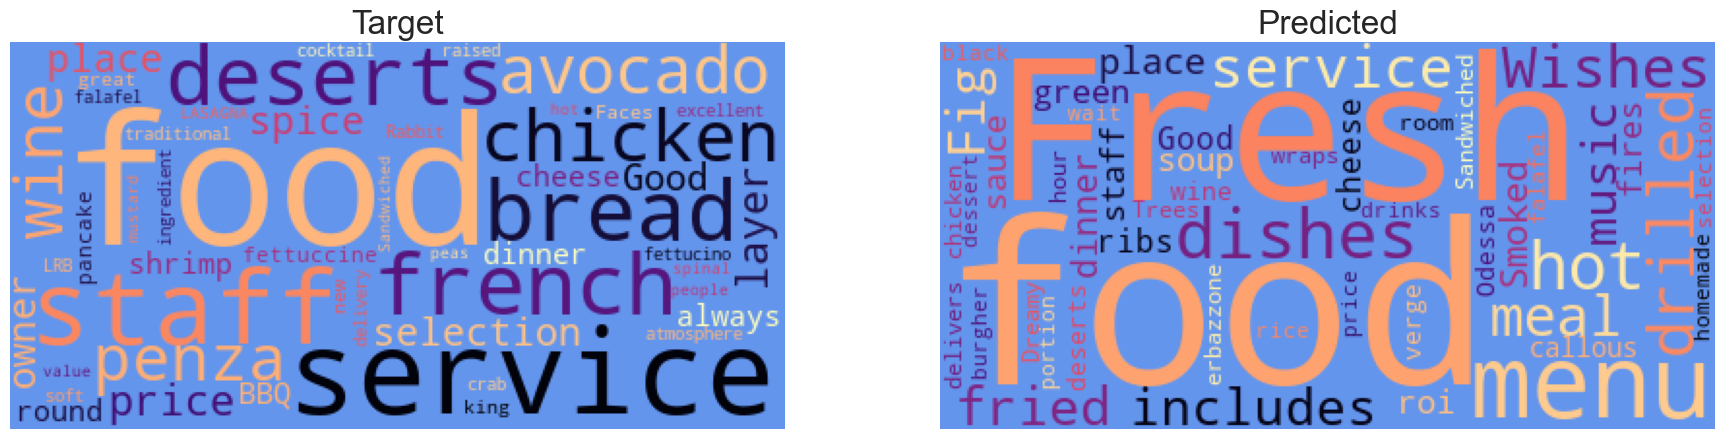

In [40]:
df_pred = pd.read_csv('../src/model_ABSA_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv')

def tokens_polarity (tokens, polarity_data):

    #string to list
    tokens = [t.strip('][').split(', ') for t in tokens]
    polarity_data = [p.strip('][').split(', ') for p in polarity_data]
    polarity_data = [[int(i) if i != 'None' else None for i in p] for p in polarity_data]
    positive = []
    negative = []
    neutral = []
    for p in polarity_data: #each p is a list
        for pp in p:
            t = tokens[polarity_data.index(p)][p.index(pp)][1:-1]
            if pp is not None:
                if pp == 1:
                    positive.append(t)
                elif pp == -1:
                    negative.append(t)
                elif pp == 0:
                    neutral.append(t)
    return positive, negative, neutral

pred_pos, pred_neg, pred_neut = tokens_polarity(df_pred['Tokens'].values, df_pred['Predicted'].values)
gold_pos, gold_neg, gold_neut = tokens_polarity(df_pred['Tokens'].values, df_pred['Actual'].values)

print ('POSITIVE ASPECTS')
target_predicted_wordcloud(' '.join(gold_pos), ' '.join(pred_pos), "../results_ABSA/adapter_positive_wordcloud.pdf")


NEGATIVE ASPECTS


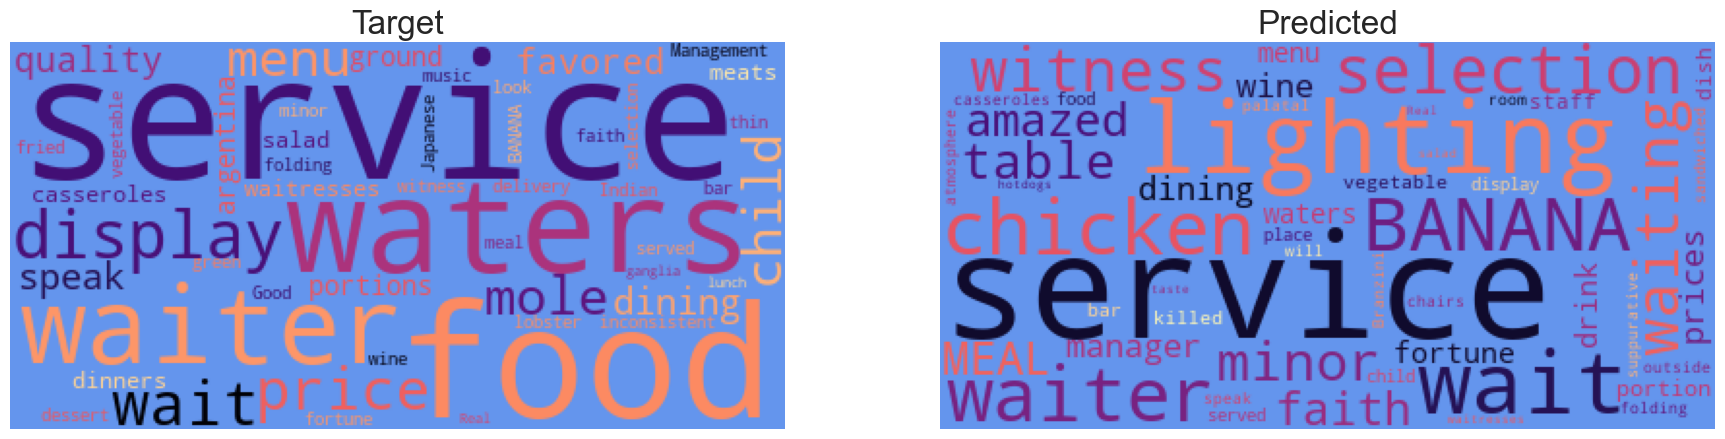

In [42]:
print ('NEGATIVE ASPECTS')
target_predicted_wordcloud(' '.join(gold_neg), ' '.join(pred_neg), "../results_ABSA/adapter_negative_wordcloud.pdf")   

NEUTRAL ASPECTS


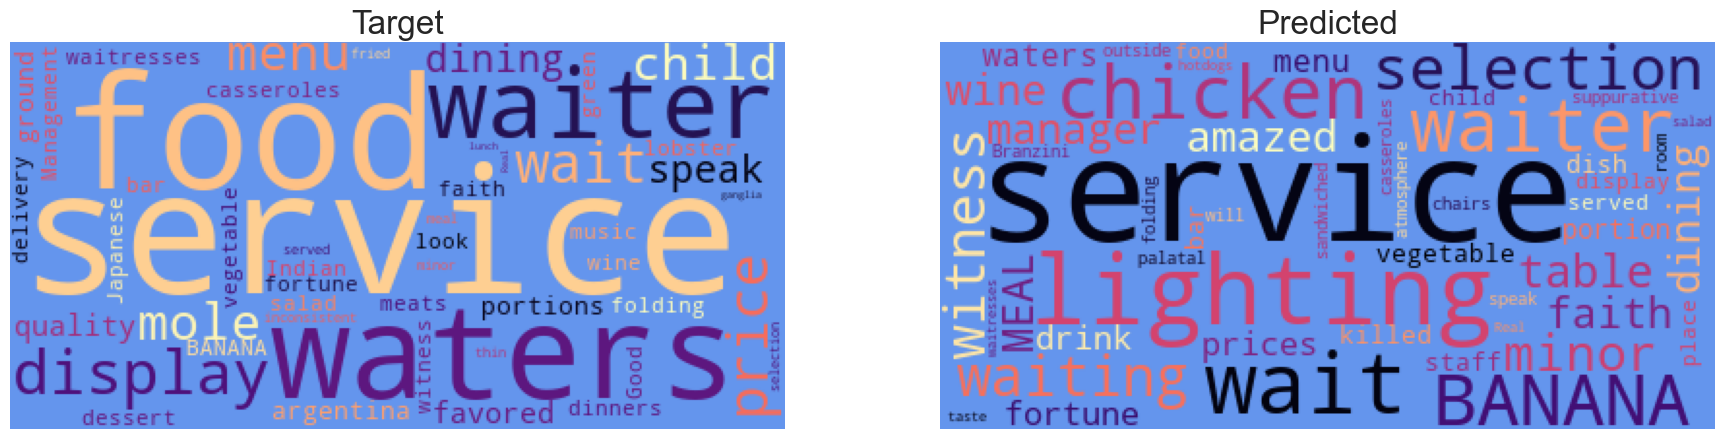

In [43]:
print ('NEUTRAL ASPECTS')
target_predicted_wordcloud(' '.join(gold_neg), ' '.join(pred_neg), "../results_ABSA/adapter_neutral_wordcloud.pdf")   